## Simple Martingale Strategy

__使用说明__
- 按照顺序每个格子运行，选中格子，用shift+回车运行，如果有返回，返回结果直接会在下面显示，错误也是
- 这个示例里，只要定义一下 dataset的文件名就可以运行了。

Last Update: 2022.3.21

__input your data file name here__

In [ ]:
dataset_filename = "LUNAUSDT-2020-08-21-2022-03-21.csv"

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
import datetime
import argparse

__Here defines some broker info__

In [ ]:
class BinanceComissionInfo(bt.CommissionInfo):
    params = (
        ("commission", 0.075),
        ("mult", 1.0),
        ("margin", None),
        ("commtype", bt.CommInfoBase.COMM_PERC),
        ("stocklike", True),
        ("percabs", False),
        ("interest", 0.0),
        ("interest_long", False),
        ("leverage", 1.0),
        ("automargin", False),
    )
    
    def getsize(self, price, cash):
        """Returns fractional size for cash operation @price"""
        return self.p.leverage * (cash / price)


__Here defines several indicator used by strategy__

In [ ]:
class DynamicHighest(bt.Indicator):
    lines = ('dyn_highest',)
    #plotlines = dict( dyn_highest = dict(_skipnan=False))

    def __init__(self):
        self._tradeopen = False

    def tradeopen(self, yesno):
        self._tradeopen = yesno

    def next(self):
        if self._tradeopen:
            self.lines.dyn_highest[0] = max(self.data[0], self.dyn_highest[-1])

class DynamicLowest(bt.Indicator):
    lines = ('dyn_lowest',)
    #plotlines = dict( dyn_lowest = dict(_skipnan=False))

    def __init__(self):
        self._tradeopen = False
        self.counter = 0

    def tradeopen(self, yesno):
        self._tradeopen = yesno

    def next(self):
        if self._tradeopen:
            self.lines.dyn_lowest[0] = min( self.data[0], self.dyn_lowest[-1])


In [ ]:
class MartingaleSize():

    def __init__(self):
        self.double_time = 1
        self.init_cap = 20

    def double(self):
        self.double_time *= 2

    def reset(self):
        self.double_time = 1

    def getsize(self, cash):
        try_size = self.init_cap * self.double_time
        self.double()
        if cash < try_size:
            return cash
        return try_size

In [ ]:
def pct_chg(p1,p2):
    return (p1-p2)/p2

__here is the strategy itself__

In [ ]:
class Martingale(bt.Strategy):
    # sell mark:    price higher 1.3% than average holding cost
    # sell trigger: price retract from high 0.3%
    # buy mark:     price lower than 4% of average holding cost
    # buy trigger:  price rebounce 0.5% after buy mark

    params = (
        ("sell_mark", 0.013),
        ("sell_signal", -0.003),
        ("buy_mark", -0.04),
        ("buy_signal", 0.005),
        # Percentage of portfolio for a trade. Something is left for the fees
        # otherwise orders would be rejected
        ("portfolio_frac", 0.98),
        ("debug", False),

    )

    def __init__(self):
        self.val_start = self.broker.getcash()  # keep the starting cash
        self.size = None
        self.order = None

        self.dyn_highest = DynamicHighest( self.data.high, subplot=False )
        self.dyn_lowest = DynamicLowest( self.data.low, subplot=False )

        self.reset_mark()

        self.size_calc = MartingaleSize()

    def log(self, txt, dt=None):
        if self.p.debug:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def reset_mark(self):
        self.sell_mark = False
        self.buy_mark = False

    def next(self):

        available_cash = self.broker.getcash() * self.p.portfolio_frac

        if not self.position:  # not in the market
            # buy in now
            self.size_calc.reset() # reset to 1
            self.size =  self.size_calc.getsize( available_cash ) / self.data.lines.close[0]  # strating from 10u
            self.order = self.buy(size=self.size)

            # reset all mark
            self.reset_mark()

            print(
                "Enter Market:"
                f"DateTime {self.datas[0].datetime.datetime(0)}, "
                f"Price {self.data[0]:.2f}, "
                f"Amount {self.size}"
            )

        else:  # in the market

            if self.p.debug:
                print(
                    (
                        f"TradeOpen: {self.dyn_highest._tradeopen},"
                        f"Dyn Highest:{self.dyn_highest[0]},"
                        f"Dyn Lowest:{self.dyn_lowest[0]},"
                    )
                )

            # process buy/sell first
            if self.sell_mark and (
                    pct_chg(self.data.lines.low[0], self.dyn_highest[0]) < self.p.sell_signal):
                # sell all
                self.order = self.close()
                self.reset_mark()

                print(
                    (
                        f"Leave Market:"
                        f"DateTime {self.datas[0].datetime.datetime(0)}, "
                        f"Market Price {self.data[0]:.2f}, "
                        f"Market Low {self.data.lines.low[0]:.2f},"
                        f"Position Cost {self.position.price}， "
                        f"Position Size {self.position.size}， "
                        f"Recent High {self.dyn_highest[0]} "
                    )
                )

                return

            if self.buy_mark and (
                    pct_chg(self.data.lines.high[0], self.dyn_lowest[0]) > self.p.buy_signal):
                # buy
                self.size = self.size_calc.getsize( available_cash ) / self.data.lines.close[0]  # strating from 10u
                self.order = self.buy(size=self.size)
                self.reset_mark()

                print(
                    (
                        f"Double Bet:"
                        f"DateTime {self.datas[0].datetime.datetime(0)}, "
                        f"Market Price {self.data[0]:.2f},"
                        f"Market High  {self.data.lines.high[0]:.2f},"
                        f"Position Cost {self.position.price}， "
                        f"Position Size {self.position.size}， "
                        f"Recent Low {self.dyn_lowest[0]} "
                    )
                )
                return

            if (pct_chg(self.data.lines.high, self.position.price) > self.p.sell_mark):
                self.sell_mark = True

            if (pct_chg(self.data.lines.low, self.position.price) < self.p.buy_mark):
                self.buy_mark = True

        #if self.order:
        #    return  # pending order execution. Waiting in orderbook

        #print(
        #        f"DateTime {self.datas[0].datetime.datetime(0)}, "
        #        f"Price {self.data[0]:.2f}, "
        #        f"Position {self.position.upopened}"
        #    )

    def notify_order(self, order):
        """Execute when buy or sell is triggered
        Notify if order was accepted or rejected
        """
        if order.alive():
            print(f"Order is alive: {self.datas[0].datetime.datetime(0)}")

            # submitted, accepted, partial, created
            # Returns if the order is in a status in which it can still be executed
            return

        order_side = "Buy" if order.isbuy() else "Sell"
        if order.status == order.Completed:
            print(
                (
                    f"{order_side} Order Completed - Datetime{self.datas[0].datetime.datetime(0)} "
                    f"Size: {order.executed.size} "
                    f"@Price: {order.executed.price} "
                    f"Value: {order.executed.value:.2f} "
                    f"Comm: {order.executed.comm:.6f} "
                )
            )
        elif order.status in {order.Canceled, order.Margin, order.Rejected}:
            print(f"{order_side} Order Canceled/Margin/Rejected")
        self.order = None  # indicate no order pending

    def notify_trade(self, trade):
        """Execute after each trade
        Calcuate Gross and Net Profit/loss"""

        self.dyn_highest.tradeopen(trade.isopen)
        self.dyn_lowest.tradeopen(trade.isopen)

        # trade closed
        if trade.isclosed:
            print(f"Operational profit, Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}")

    def stop(self):
        """ Calculate the actual returns """
        self.roi = (self.broker.getvalue() / self.val_start) - 1.0
        val_end = self.broker.getvalue()
        print(
            f"ROI: {100.0 * self.roi:.2f}%%, Start cash {self.val_start:.2f}, "
            f"End cash: {val_end:.2f}"
        )


__Below Runs the Strategy__

In [ ]:
# Create a cerebro entity
cerebro = bt.Cerebro(runonce=False,
                    preload=False,
                    )


# Create a Data Feed
data = bt.feeds.GenericCSVData(
    dataname=dataset_filename,
    dtformat="%Y-%m-%dT%H:%M:%S",
    timeframe=bt.TimeFrame.Ticks
)

# Add the Data Feed to Cerebro
cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=1)

# Add a Commission and Support Fractional Size
cerebro.broker.addcommissioninfo(BinanceComissionInfo())

# Set our desired cash start
cerebro.broker.setcash(10000)

# Add a strategy
cerebro.addstrategy(Martingale)

# Add Oberserver
cerebro.addobserver(bt.observers.DrawDown)

# Analyzer
cerebro.addanalyzer(
    bt.analyzers.SharpeRatio,
    timeframe=bt.TimeFrame.Days,
    riskfreerate=0,
    _name='dailysharp'
    )


# Add PyFolio, but this is quite problematic
cerebro.addanalyzer(
    bt.analyzers.PyFolio, # PyFlio only work with daily data
    timeframe=bt.TimeFrame.Days,
)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Add a writer
# csv_out = 'test.csv'
# cerebro.addwriter(bt.WriterFile, csv=args.writercsv, out=csv_out)

# Run over everything
results = cerebro.run()


# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())




In [ ]:
#cerebro.plot(iplot=True, style="bar")


__Retrive pyfolio Items__

In [ ]:
st0 = results[0]

#for alyzer in st0.analyzers:
#    alyzer.print()

pyfoliozer = st0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()


__write pyfolio needed positions/returns/transactions into file so that next time you don't need to run strats__

In [2]:
path = 'LUNA-Martingale-2022-03-22/'
returns_filename="returns.csv"
positions_filename="positions.csv"
transactions_filename="transactions.csv"

In [2]:
returns.to_csv(path+returns_filename)
positions.to_csv(path+positions_filename)
transactions.to_csv(path+transactions_filename)

NameError: name 'returns' is not defined

__read back from file, DO NOT RUN if just finish sim__

In [3]:
returns = pd.read_csv(path+returns_filename)
positions = pd.read_csv(path+positions_filename)
transactions = pd.read_csv(path+transactions_filename)


# Process Returns
returns["index"] = pd.to_datetime(returns["index"])
returns.set_index( 'index', inplace=True)
returns = returns.squeeze()
#print( returns.info() )

# Process Positions
positions["Datetime"] = pd.to_datetime(positions["Datetime"])
positions.set_index( 'Datetime', inplace=True)
#print( positions.info())

# Process Transactions
transactions["date"] =  pd.to_datetime(transactions["date"])
transactions.set_index( 'date', inplace=True)
#print( transactions.info())


__Return Tear Sheet__

In [1]:
import pandas as pd
import pyfolio as pf
import empyrical as ep
import numpy as np

%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/Users/michael/Projects/pyfolio/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


=========================================================
## 关于pyfolio input data的要求：
- returns: daily returns indexed by date
- posiitons: daily net positions indexed by date
- transactions: every transactions indexed by transaction datetime

一共有几个总的tear sheet：
- returns tear sheet
- round trip tear sheet
- position tear sheet
- transaction tear sheet
这些tear sheet 是可以单个跑的

Start date,2020-08-21
End date,2022-03-21
Total months,19
,Backtest
Annual return,34.195%
Cumulative returns,59.272%
Annual volatility,48.54%
Sharpe ratio,0.82
Calmar ratio,1.09
Stability,0.96
Max drawdown,-31.301%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.30,2021-05-22,2021-05-23,2021-05-24,1
1,5.46,2021-05-18,2021-05-19,2021-05-20,3
2,0.86,2021-09-27,2021-09-28,2021-09-29,3
3,0.59,2021-05-02,2021-05-10,2021-05-13,9
4,0.45,2021-12-09,2021-12-10,2021-12-11,2


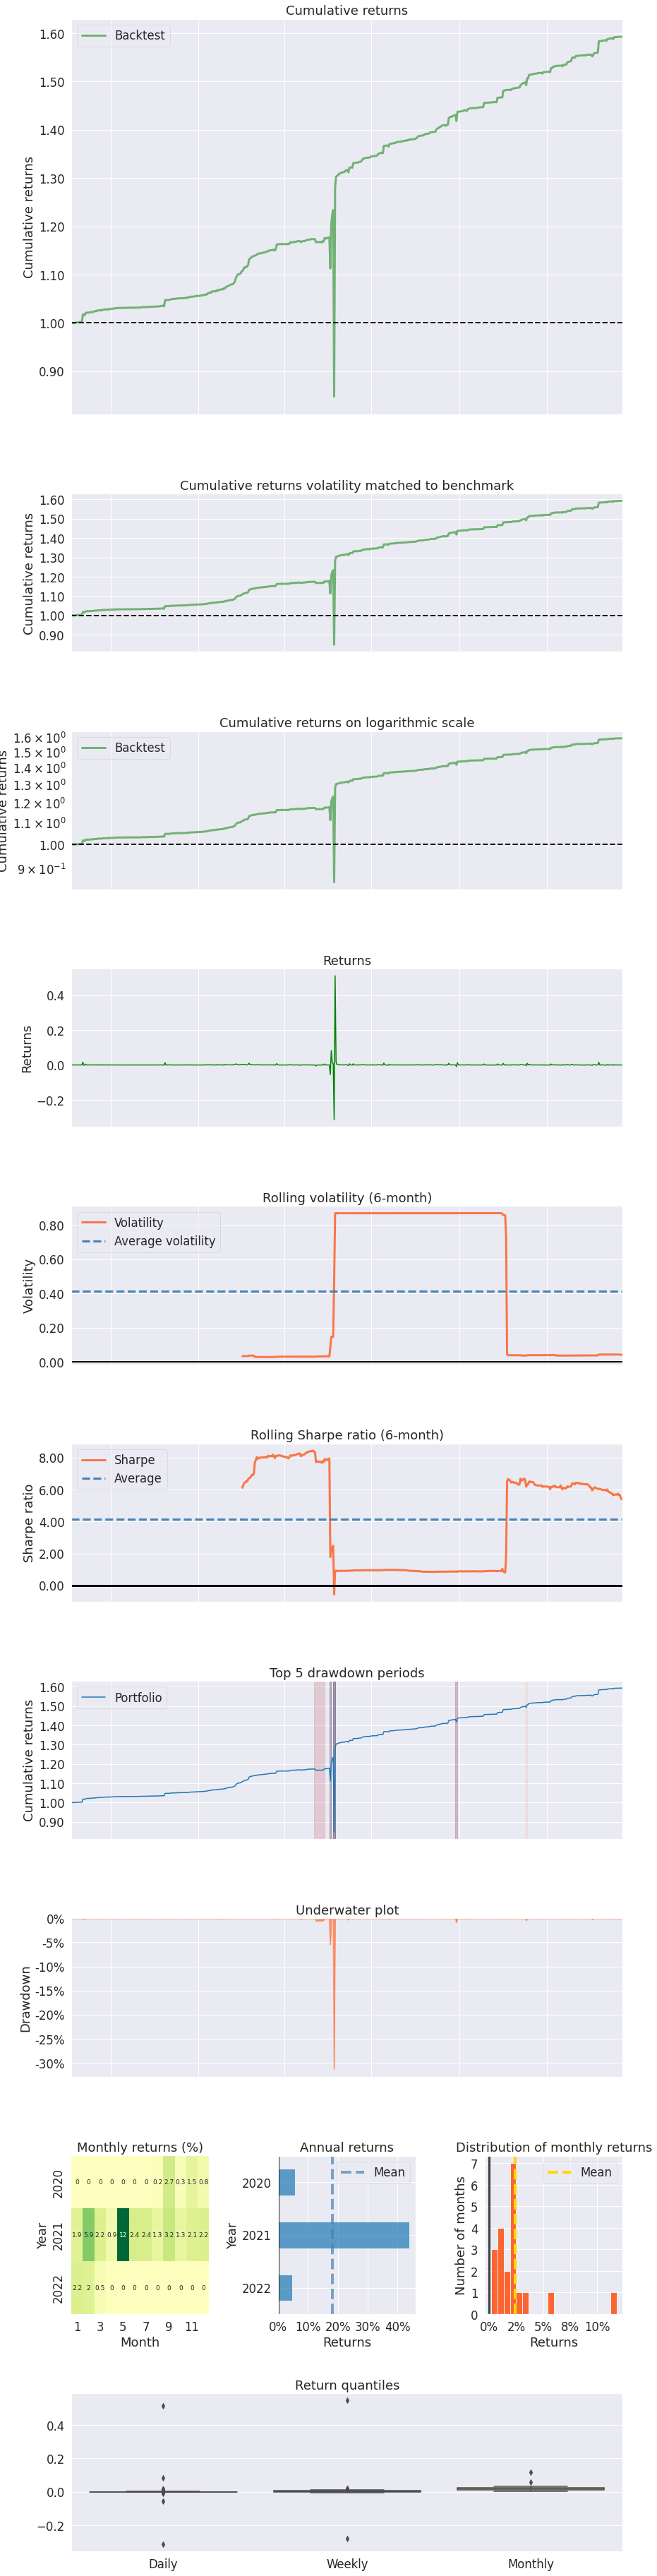

In [72]:
pf.create_returns_tear_sheet(returns)

__Return Tear Sheet个别图单独画__

In [ ]:
# print performance stats
pf.show_perf_stats(returns)

In [ ]:
# drawdown table
drawdown_df = pf.timeseries.gen_drawdown_table(returns)
drawdown_df

In [ ]:
# plot drawdown underwater
pf.plot_drawdown_underwater(returns)

In [ ]:
# plot draw down periods
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [ ]:
# daily return plot
pf.plot_returns(returns).set_xlabel('date')

In [ ]:
# plot rolling returns
pf.plot_rolling_returns(returns)

In [ ]:
# calc max cum returns
ep.cum_returns(returns).max()

In [ ]:
# plot annual returns
pf.plot_annual_returns(returns)

In [ ]:
# monthly return heatmap
pf.plotting.plot_monthly_returns_heatmap(returns)

In [ ]:
# monthly return dist
pf.plotting.plot_monthly_returns_dist(returns)

In [ ]:
# plot rolling sharp
pf.plot_rolling_sharpe(returns)

In [ ]:
# plot rolling volatility
pf.plot_rolling_volatility(returns)

__Trade and Position Analysis__

Summary stats,All trades,Long trades
Total number of round_trips,3987.0000,3987.0000
Percent profitable,0.9712,0.9712
Winning round_trips,3872.0000,3872.0000
Losing round_trips,113.0000,113.0000
Even round_trips,2.0000,2.0000


PnL stats,All trades,Long trades
Total profit,$7102.2385,$7102.2385
Gross profit,$7296.8719,$7296.8719
Gross loss,$-194.6334,$-194.6334
Profit factor,$37.4903,$37.4903
Avg. trade net profit,$1.7813,$1.7813
Avg. winning trade,$1.8845,$1.8845
Avg. losing trade,$-1.7224,$-1.7224
Ratio Avg. Win:Avg. Loss,$1.0941,$1.0941
Largest winning trade,$464.2704,$464.2704
Largest losing trade,$-94.0132,$-94.0132


Duration stats,All trades,Long trades
Avg duration,0 days 02:41:08.833960371,0 days 02:41:08.833960371
Median duration,0 days 00:45:00,0 days 00:45:00
Longest duration,3 days 00:27:00,3 days 00:27:00
Shortest duration,0 days 00:02:00,0 days 00:02:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.0146%,0.0146%
Avg returns winning,0.0154%,0.0154%
Avg returns losing,-0.0151%,-0.0151%
Median returns all round_trips,0.0024%,0.0024%
Median returns winning,0.0024%,0.0024%
Median returns losing,-0.0012%,-0.0012%
Largest winning trade,5.4779%,5.4779%
Largest losing trade,-0.8391%,-0.8391%


Symbol stats,LUNAUSDT-2020-08-21-2022-03-21
Avg returns all round_trips,0.0146%
Avg returns winning,0.0154%
Avg returns losing,-0.0151%
Median returns all round_trips,0.0024%
Median returns winning,0.0024%
Median returns losing,-0.0012%
Largest winning trade,5.4779%
Largest losing trade,-0.8391%


Profitability (PnL / PnL total) per name,
symbol,
LUNAUSDT-2020-08-21-2022-03-21,100.00%


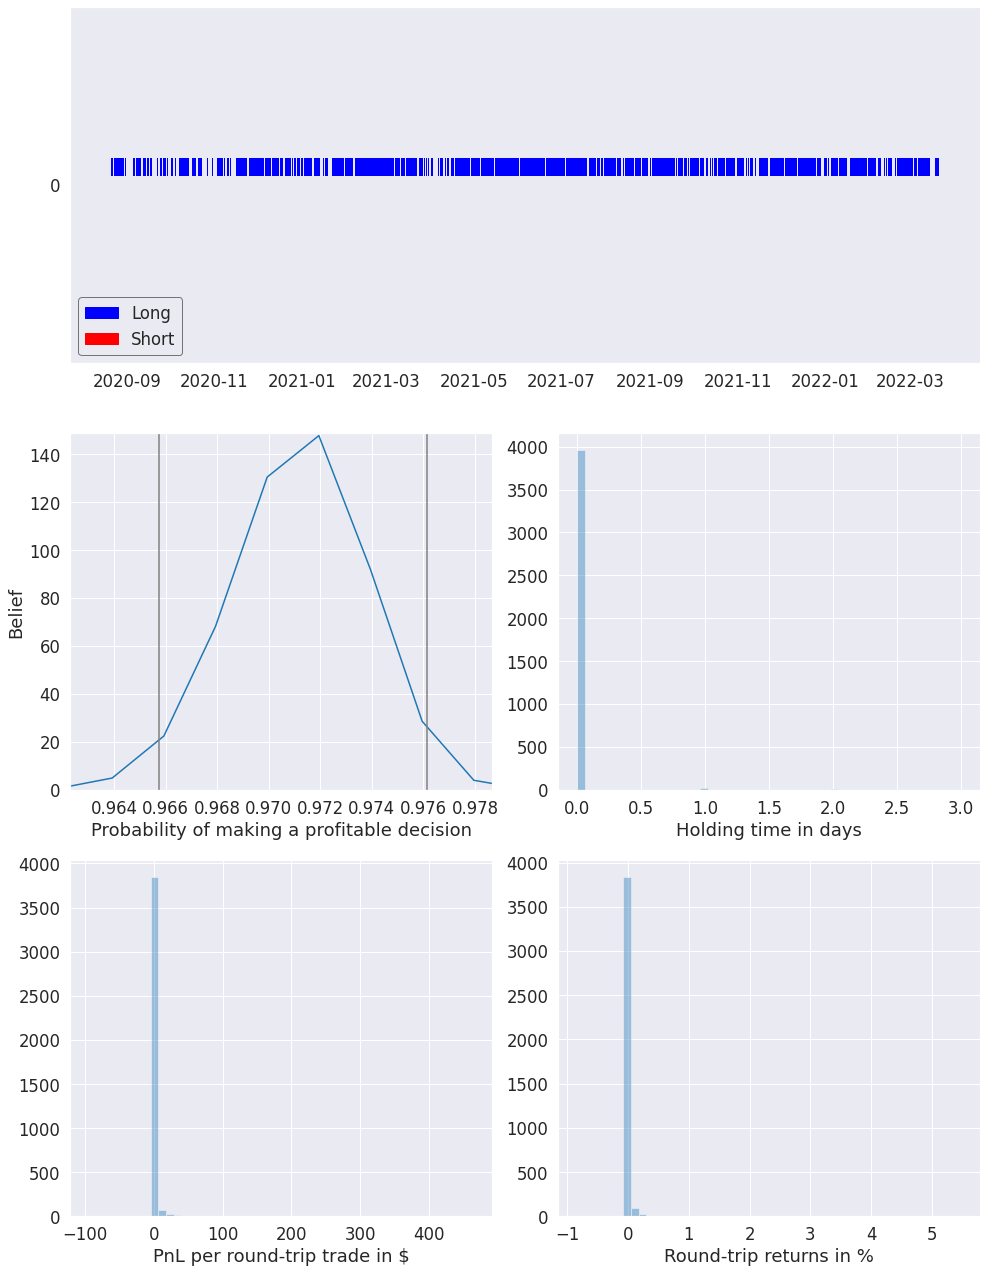

In [73]:
pf.create_round_trip_tear_sheet(returns, positions, transactions  )

Stress Events,mean,min,max
New Normal,0.11%,-31.30%,51.20%


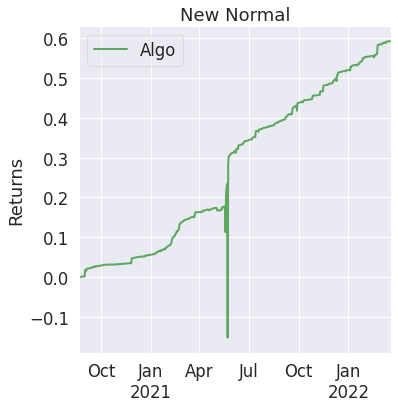

In [68]:
pf.create_interesting_times_tear_sheet(returns)

Top 10 long positions of all time,max
LUNAUSDT-2020-08-21-2022-03-21,100.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
LUNAUSDT-2020-08-21-2022-03-21,100.00%


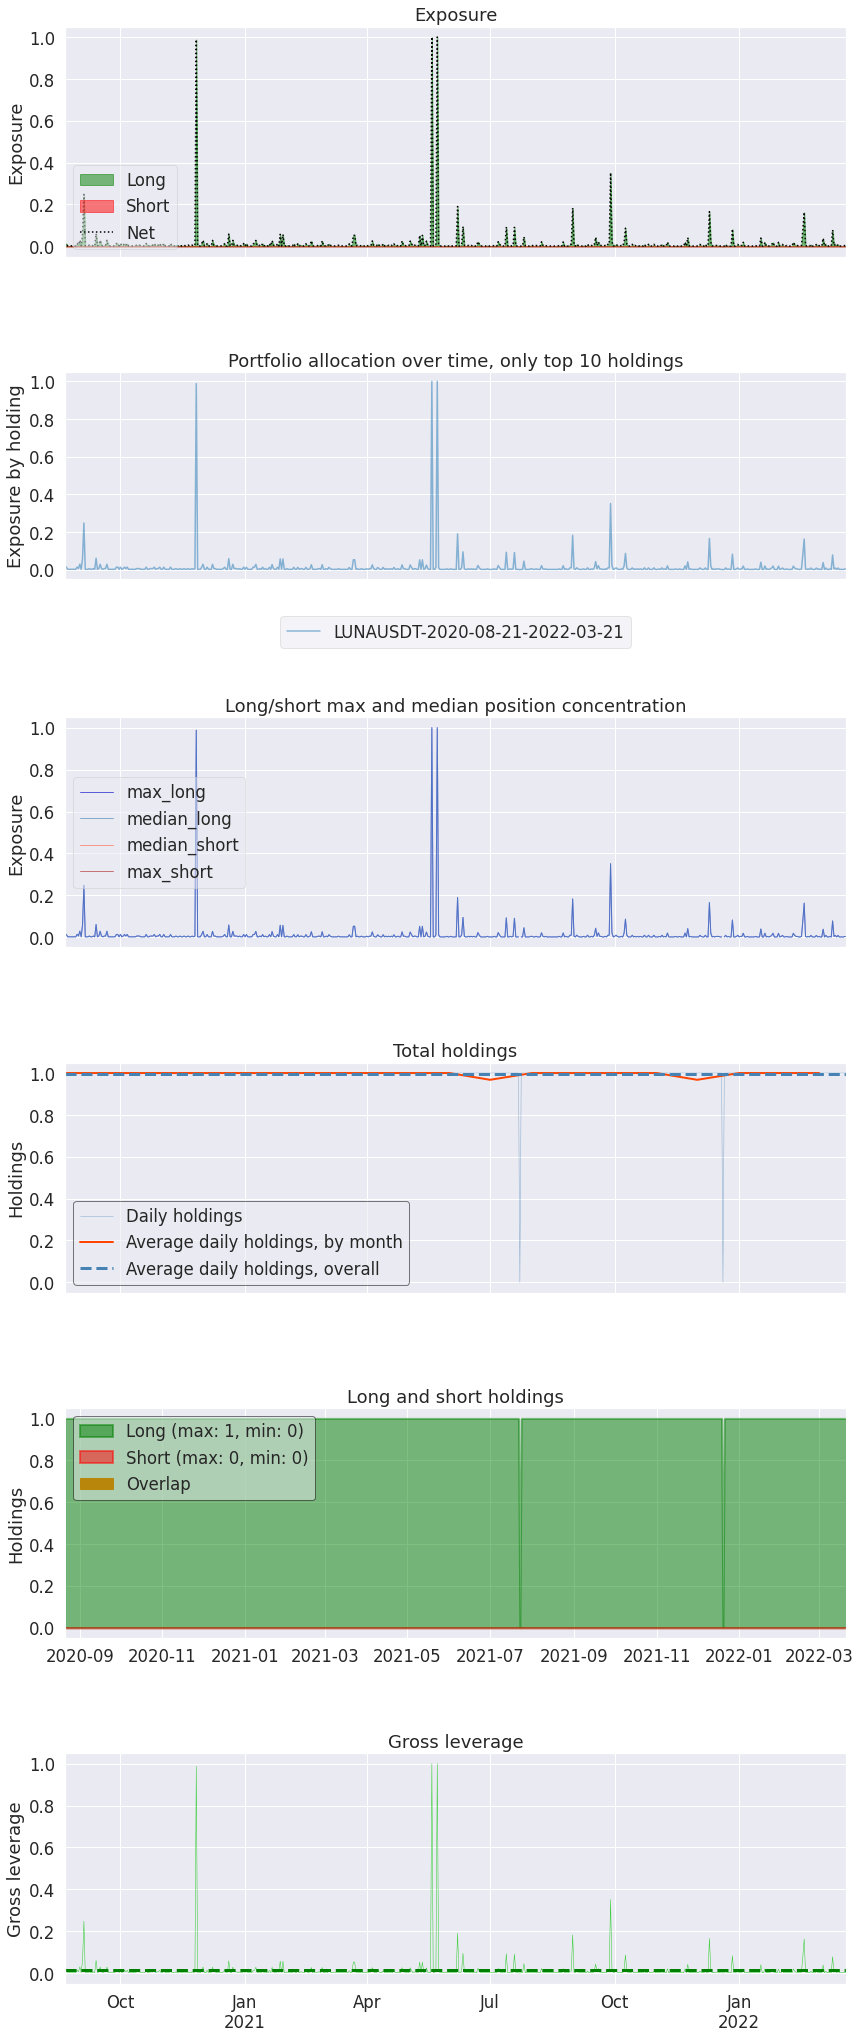

In [69]:
pf.create_position_tear_sheet(returns, positions,estimate_intraday=False)

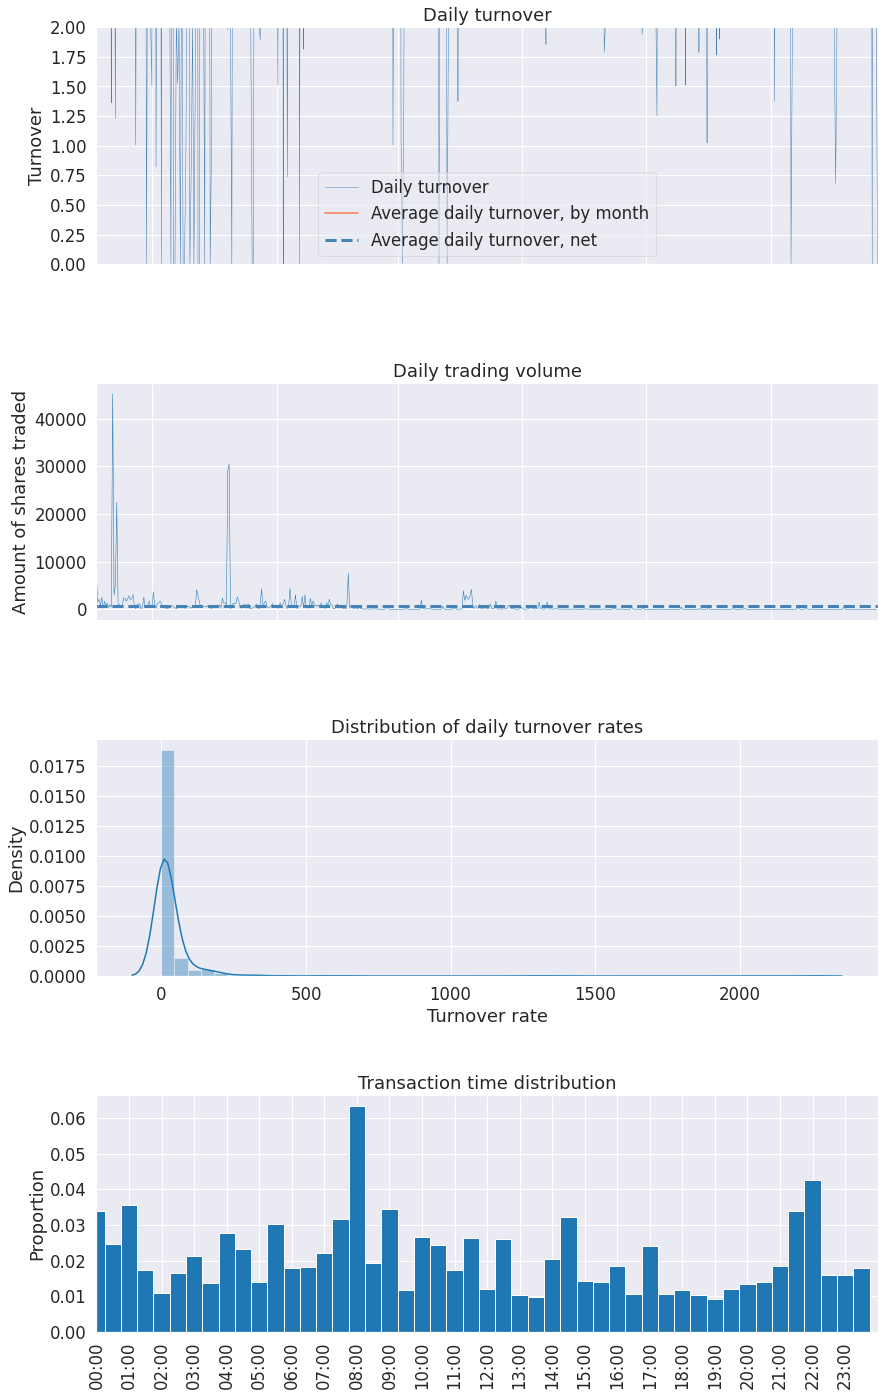

In [4]:
pf.create_txn_tear_sheet(returns, positions, transactions,estimate_intraday=False)


__All in One__

Start date,2020-08-21
End date,2022-03-21
Total months,19
,Backtest
Annual return,34.195%
Cumulative returns,59.272%
Annual volatility,48.54%
Sharpe ratio,0.82
Calmar ratio,1.09
Stability,0.96
Max drawdown,-31.301%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.30,2021-05-22,2021-05-23,2021-05-24,1
1,5.46,2021-05-18,2021-05-19,2021-05-20,3
2,0.86,2021-09-27,2021-09-28,2021-09-29,3
3,0.59,2021-05-02,2021-05-10,2021-05-13,9
4,0.45,2021-12-09,2021-12-10,2021-12-11,2


Stress Events,mean,min,max
New Normal,0.11%,-31.30%,51.20%


Top 10 long positions of all time,max
LUNAUSDT-2020-08-21-2022-03-21,100.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
LUNAUSDT-2020-08-21-2022-03-21,100.00%


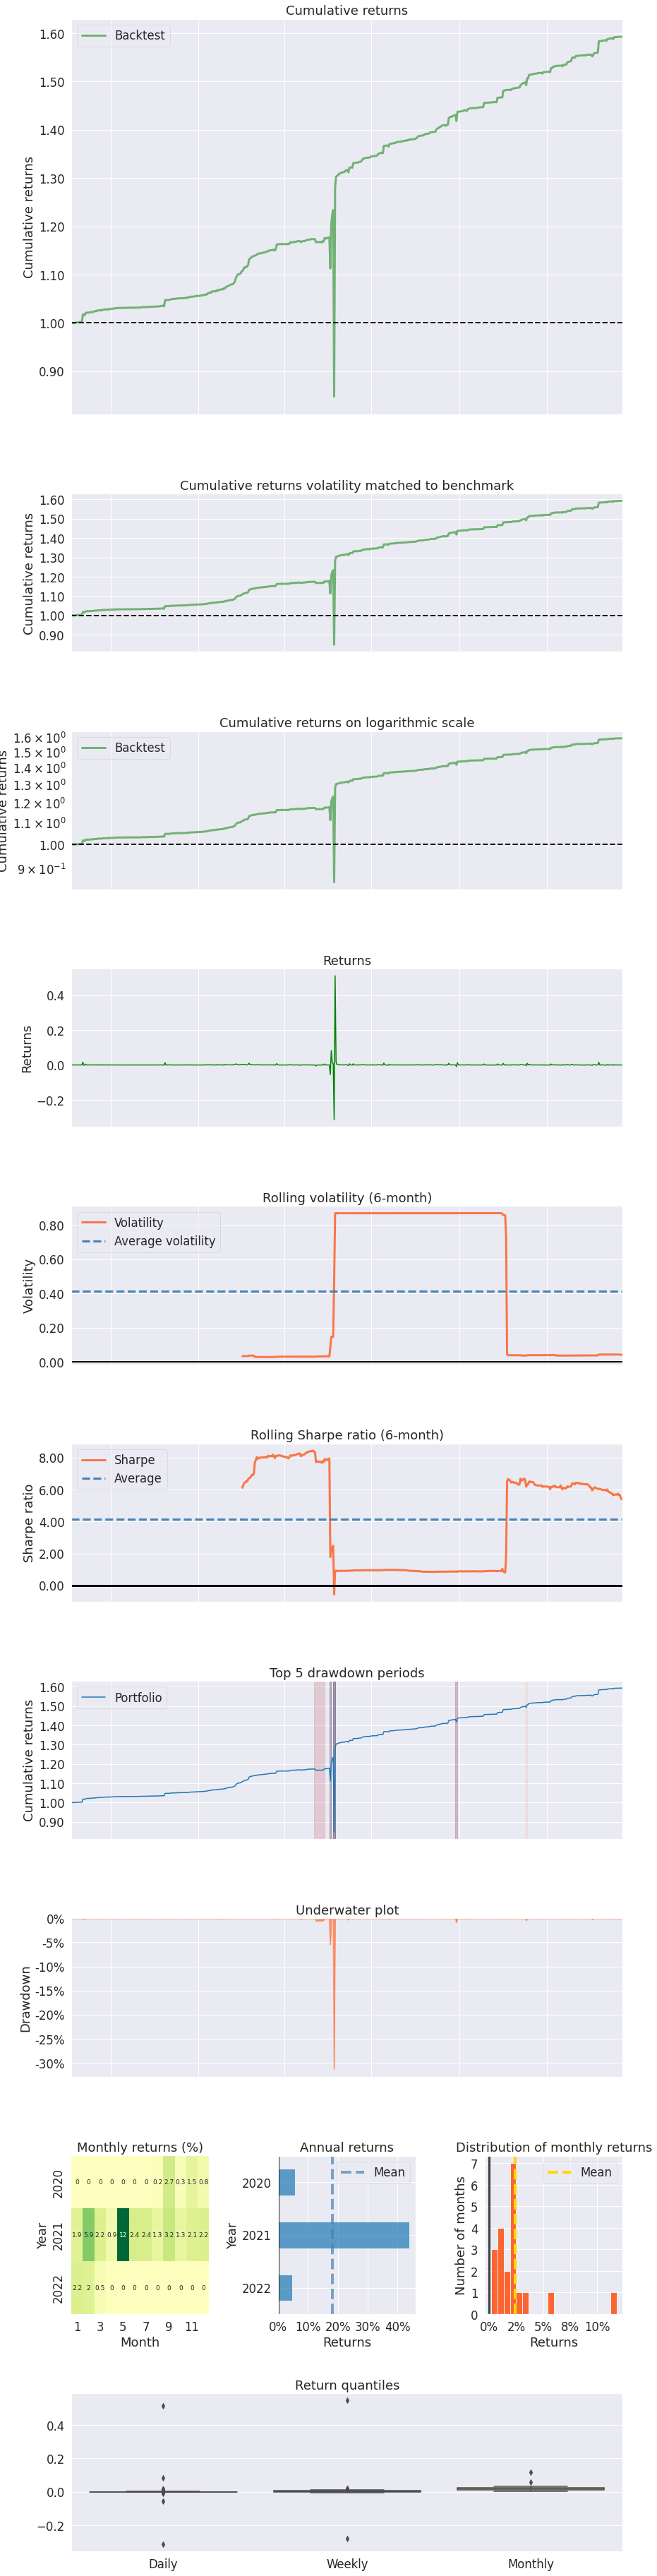

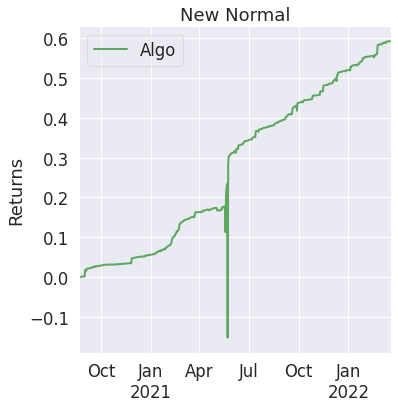

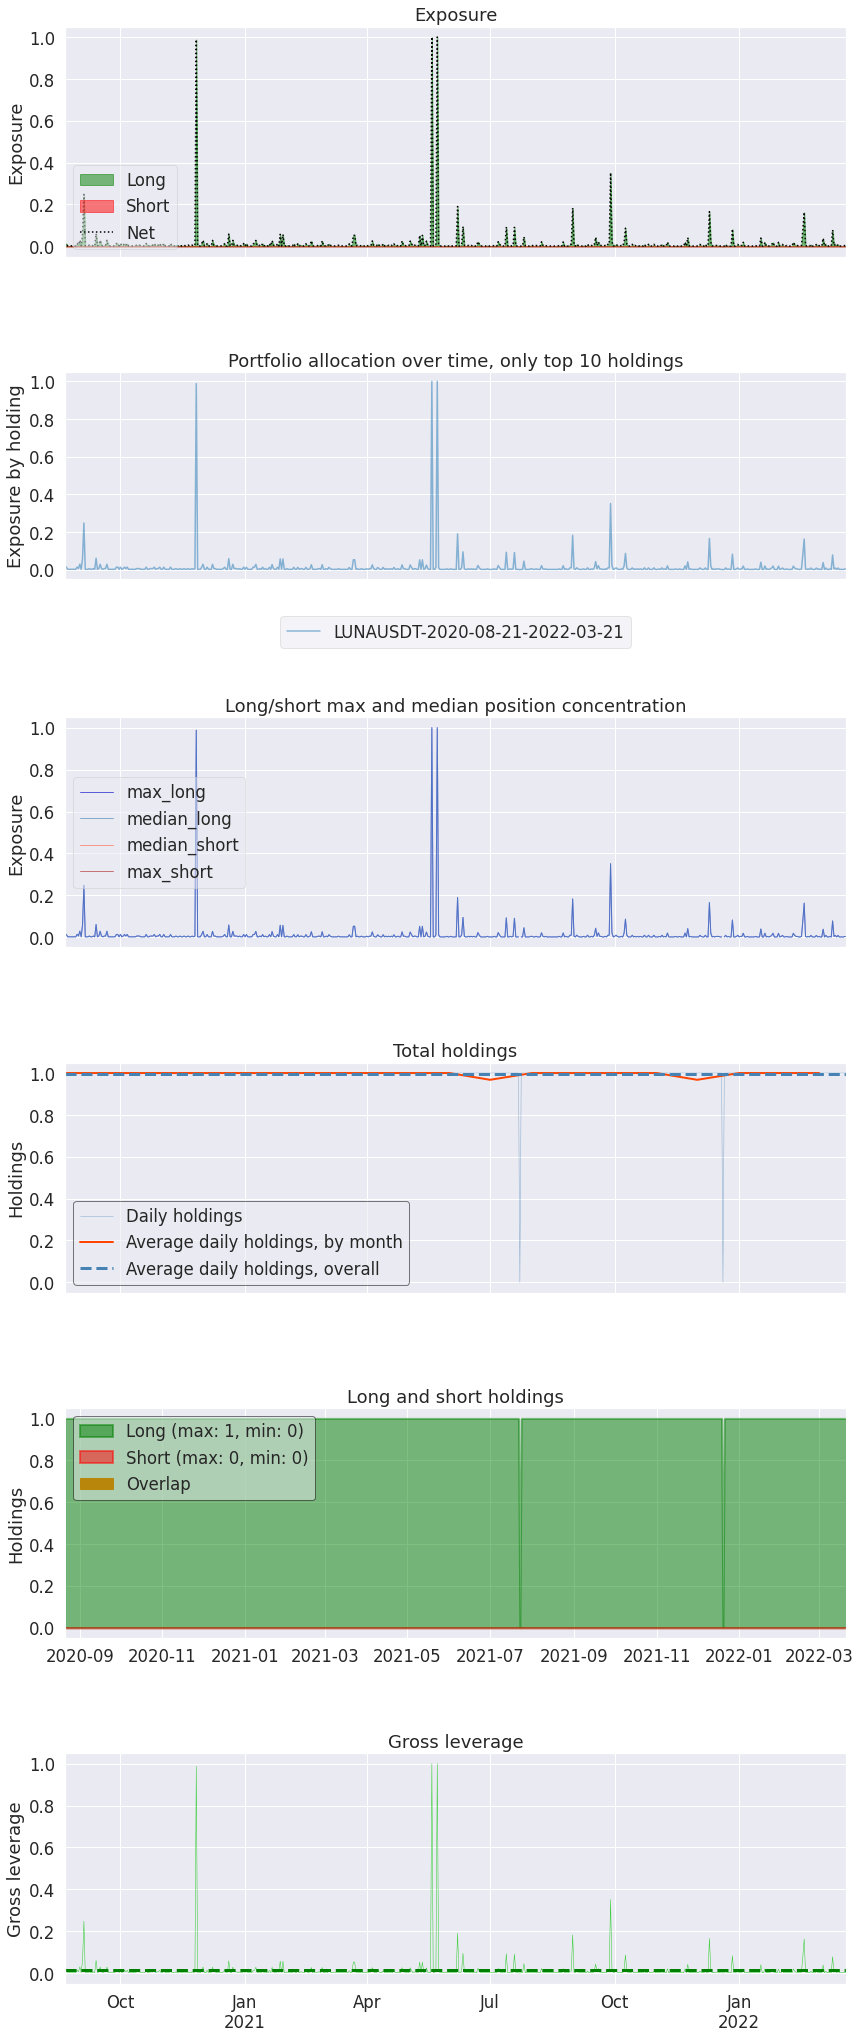

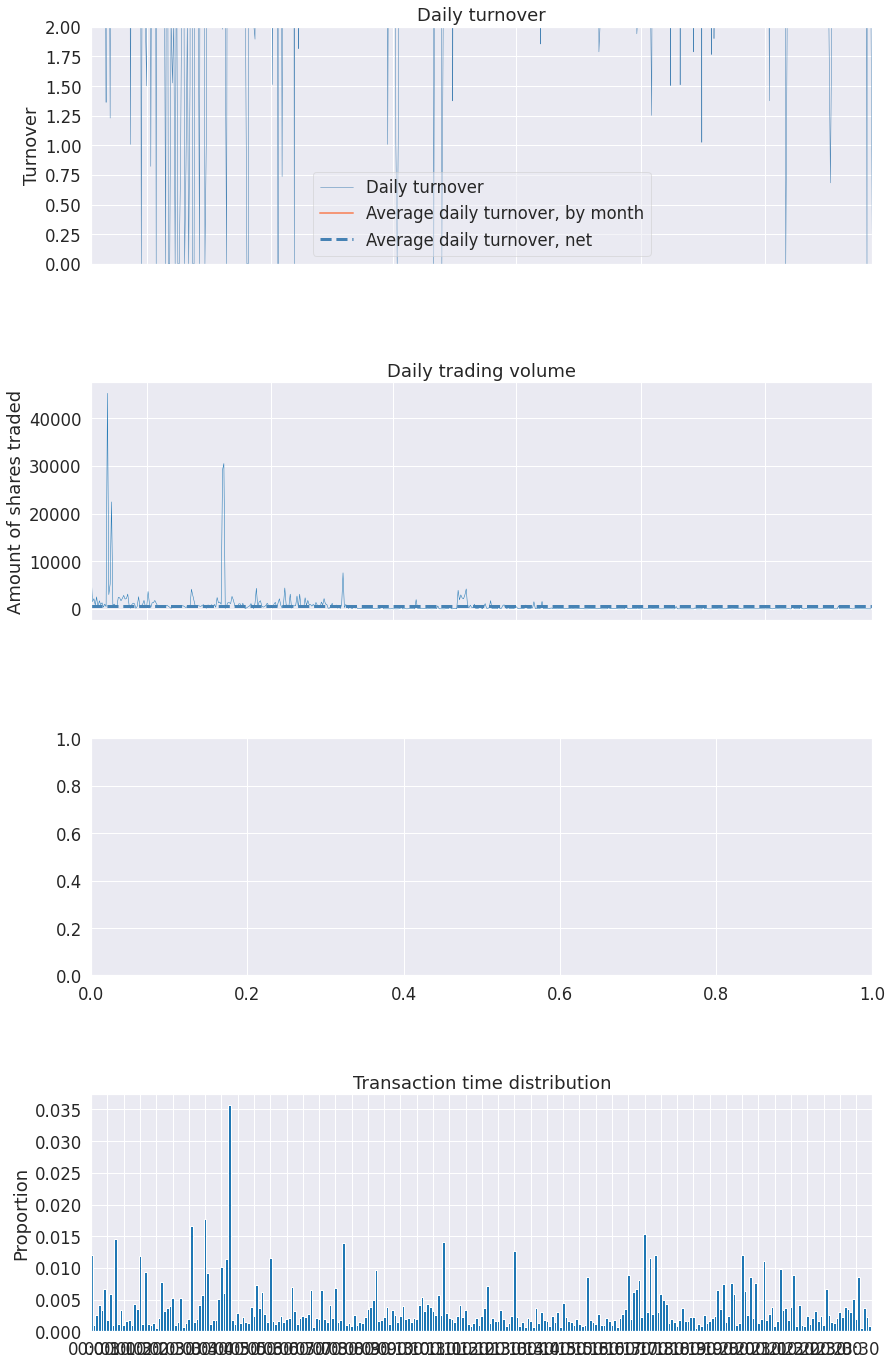

In [76]:
pf.create_full_tear_sheet(returns,positions=positions,transactions=transactions)

In [8]:
transactions.index[0].tz


<UTC>